# 第一阶段：ETT 数据预处理与探索性分析（EDA）

- 目标：
  - 熟悉 ETT 数据格式（时间序列、电力指标、油温 OT）。
  - 完成缺失值/异常值检测与清洗。
  - 完成特征缩放（标准化/归一化），导出清洗后数据。
  - 完成 OT 相关性与时序特性分析，可视化并导出图表。
- 数据源：`ETDataset-main/ETT-small/ETTh1.csv`, `ETTh2.csv`, `ETTm1.csv`, `ETTm2.csv`（可自行切换）。
- 运行环境：`Python (ETD-Env)`。
- 输出路径：`project/first/outputs/cleaned`（数据）、`project/first/outputs/figures`（图表）。


In [35]:
# 基础设置与依赖导入
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns

# Matplotlib 中文显示设置
preferred_cn_fonts = ['Microsoft YaHei','SimHei','PingFang SC','WenQuanYi Zen Hei','Noto Sans CJK SC','Source Han Sans SC']
installed_fonts = set(f.name for f in font_manager.fontManager.ttflist)
for _font in preferred_cn_fonts:
    if _font in installed_fonts:
        plt.rcParams['font.sans-serif'] = [_font]
        plt.rcParams['axes.unicode_minus'] = False
        print(f'已设置中文字体: {_font}')
        break
else:
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
    print('未发现常见中文字体，已回退 DejaVu Sans；如有乱码请安装中文字体。')

from pathlib import Path
from typing import Tuple, Dict

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf

# 路径设置

def find_ett_small_dir() -> Path:
    cwd = Path.cwd()
    for base in [cwd, *cwd.parents]:
        candidate = base / 'ETDataset-main' / 'ETT-small'
        if candidate.exists():
            return candidate
    raise FileNotFoundError(f"未找到数据目录 'ETDataset-main/ETT-small'，当前工作目录: {cwd}")

DATA_DIR = find_ett_small_dir()
OUTPUT_DIR = Path('outputs')
FIG_DIR = OUTPUT_DIR / 'figures'
CLEAN_DIR = OUTPUT_DIR / 'cleaned'
FIG_DIR.mkdir(parents=True, exist_ok=True)
CLEAN_DIR.mkdir(parents=True, exist_ok=True)

# 可选数据文件
CSV_FILE = 'ETTh1.csv'  # 可改为 ETTh2.csv / ETTm1.csv / ETTm2.csv
DATA_PATH = DATA_DIR / CSV_FILE
print(f'使用数据文件: {DATA_PATH}')


已设置中文字体: Microsoft YaHei
使用数据文件: c:\Users\31518\Desktop\ETDataset-OT-Predict\ETDataset-OT-Predict\ETDataset-main\ETT-small\ETTh1.csv


In [36]:
# 批量处理 ETT-small 下的所有数据集
from datetime import datetime

REMOVE_OUTLIER_ROWS = False
WINSORIZE = True
USE_STANDARD_SCALER = True

CSV_LIST = sorted([p.name for p in DATA_DIR.glob('ETT*.csv')])
print('将批量处理以下数据集:', CSV_LIST)


def process_dataset(csv_file: str) -> None:
    print(f"\n===== 开始处理: {csv_file} =====")
    data_path = DATA_DIR / csv_file
    assert data_path.exists(), f'数据文件不存在: {data_path}'

    # 加载与基本检查
    df = pd.read_csv(data_path)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').drop_duplicates(subset=['date']).reset_index(drop=True)

    # 列信息
    value_cols = [c for c in df.columns if c != 'date']

    # 缺失值插补
    imputer = SimpleImputer(strategy='median')
    df[value_cols] = imputer.fit_transform(df[value_cols])

    # IQR 异常检测
    Q1 = df[value_cols].quantile(0.25)
    Q3 = df[value_cols].quantile(0.75)
    IQR = Q3 - Q1
    is_outlier = (df[value_cols] < (Q1 - 1.5 * IQR)) | (df[value_cols] > (Q3 + 1.5 * IQR))
    df['outlier_any'] = is_outlier.any(axis=1)

    # 清洗
    clean_df = df.copy()
    if REMOVE_OUTLIER_ROWS:
        clean_df = clean_df[~clean_df['outlier_any']].reset_index(drop=True)
    if WINSORIZE:
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        for col in value_cols:
            clean_df[col] = clean_df[col].clip(lower[col], upper[col])

    # 缩放
    scaler = StandardScaler() if USE_STANDARD_SCALER else MinMaxScaler()
    scaled_values = scaler.fit_transform(clean_df[value_cols])
    scaled_df = clean_df[['date']].copy()
    scaled_df[value_cols] = scaled_values

    # 导出清洗与缩放数据
    base = csv_file.replace('.csv', '')
    clean_path = CLEAN_DIR / f'{base}_clean.csv'
    scaled_path = CLEAN_DIR / f'{base}_scaled.csv'
    clean_df.to_csv(clean_path, index=False)
    scaled_df.to_csv(scaled_path, index=False)

    # 可视化与分析输出
    # 1) OT 概览
    plt.figure(figsize=(12, 3))
    plt.plot(df['date'], df['OT'], linewidth=0.8)
    plt.title('OT 概览')
    plt.xlabel('date')
    plt.ylabel('OT')
    plt.tight_layout()
    plt.savefig(FIG_DIR / f'{csv_file}_ot_overview.png', dpi=150)
    plt.close()

    # 2) OT 箱线图与分布
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    sns.boxplot(y=df['OT'], ax=axes[0])
    axes[0].set_title('OT 箱线图')
    sns.histplot(df['OT'], kde=True, ax=axes[1], bins=50)
    axes[1].set_title('OT 分布')
    plt.tight_layout()
    plt.savefig(FIG_DIR / f'{csv_file}_ot_box_hist.png', dpi=150)
    plt.close()

    # 3) 相关性与热力图
    corr = clean_df[value_cols].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('特征相关性热力图')
    plt.tight_layout()
    plt.savefig(FIG_DIR / f'{csv_file}_corr_heatmap.png', dpi=150)
    plt.close()

    # 4) OT 与各负荷散点
    load_cols = [c for c in value_cols if c != 'OT']
    num_to_plot = min(6, len(load_cols))
    fig, axes = plt.subplots(2, (num_to_plot + 1) // 2, figsize=(12, 6))
    axes = axes.flatten()
    for i, col in enumerate(load_cols[:num_to_plot]):
        axes[i].scatter(clean_df[col], clean_df['OT'], s=2, alpha=0.3)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('OT')
    plt.tight_layout()
    plt.savefig(FIG_DIR / f'{csv_file}_ot_scatter.png', dpi=150)
    plt.close()

    # 5) 时序特性：ADF 与 ACF/PACF
    ot_series = clean_df.set_index('date')['OT']
    try:
        adf_stat, p_value, usedlag, nobs, crit, icbest = adfuller(ot_series.dropna(), autolag='AIC')
        print(f'ADF: stat={adf_stat:.4f}, p={p_value:.6f}')
    except Exception as e:
        print('ADF 检验失败:', e)

    lag_n = 60 if 'm' not in csv_file else 24 * 7
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sm.graphics.tsa.plot_acf(ot_series, lags=lag_n, ax=axes[0])
    sm.graphics.tsa.plot_pacf(ot_series, lags=lag_n, ax=axes[1], method='ywm')
    axes[0].set_title('OT ACF')
    axes[1].set_title('OT PACF')
    plt.tight_layout()
    plt.savefig(FIG_DIR / f'{csv_file}_ot_acf_pacf.png', dpi=150)
    plt.close()

    # 6) 小时季节性
    df_hour = clean_df.copy()
    df_hour['hour'] = df_hour['date'].dt.hour
    hour_mean = df_hour.groupby('hour')['OT'].mean()
    plt.figure(figsize=(8,3))
    plt.plot(hour_mean.index, hour_mean.values)
    plt.title('OT 按小时平均')
    plt.xlabel('hour')
    plt.ylabel('OT')
    plt.tight_layout()
    plt.savefig(FIG_DIR / f'{csv_file}_ot_hourly_mean.png', dpi=150)
    plt.close()

    print(f"完成: {csv_file} -> 数据:{clean_path.name}, {scaled_path.name}；图表输出到 {FIG_DIR}")


for csv_file in CSV_LIST:
    try:
        process_dataset(csv_file)
    except Exception as e:
        print(f"处理 {csv_file} 失败: {e}")

print('\n全部处理完成。')



将批量处理以下数据集: ['ETTh1.csv', 'ETTh2.csv', 'ETTm1.csv', 'ETTm2.csv']

===== 开始处理: ETTh1.csv =====
ADF: stat=-3.5540, p=0.006704
完成: ETTh1.csv -> 数据:ETTh1_clean.csv, ETTh1_scaled.csv；图表输出到 outputs\figures

===== 开始处理: ETTh2.csv =====
ADF: stat=-3.5971, p=0.005816
完成: ETTh2.csv -> 数据:ETTh2_clean.csv, ETTh2_scaled.csv；图表输出到 outputs\figures

===== 开始处理: ETTm1.csv =====
ADF: stat=-4.2771, p=0.000486
完成: ETTm1.csv -> 数据:ETTm1_clean.csv, ETTm1_scaled.csv；图表输出到 outputs\figures

===== 开始处理: ETTm2.csv =====
ADF: stat=-4.0335, p=0.001245
完成: ETTm2.csv -> 数据:ETTm2_clean.csv, ETTm2_scaled.csv；图表输出到 outputs\figures

全部处理完成。


合并以下数据集: ['ETTh1.csv', 'ETTh2.csv', 'ETTm1.csv', 'ETTm2.csv']
合并后形状: (174200, 9)
列名: ['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT', 'dataset']
数值列: ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']
合并数据含任一异常比例: 0.023237657864523534
清洗后形状: (174200, 10)
已导出: outputs\cleaned\ALL_combined_clean.csv
已导出: outputs\cleaned\ALL_combined_scaled.csv


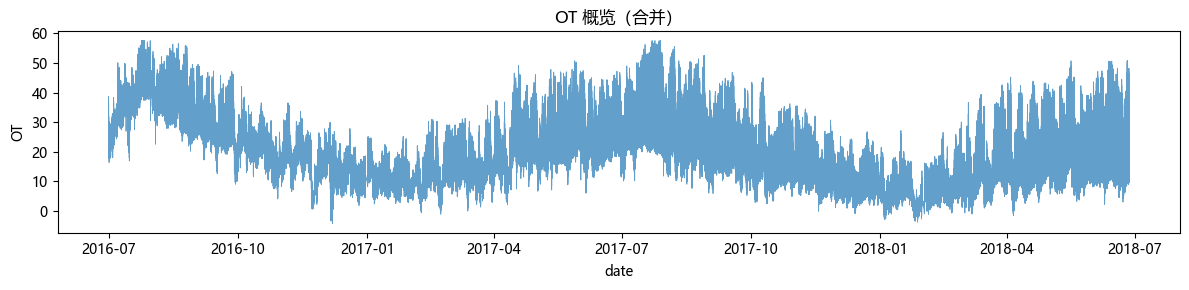

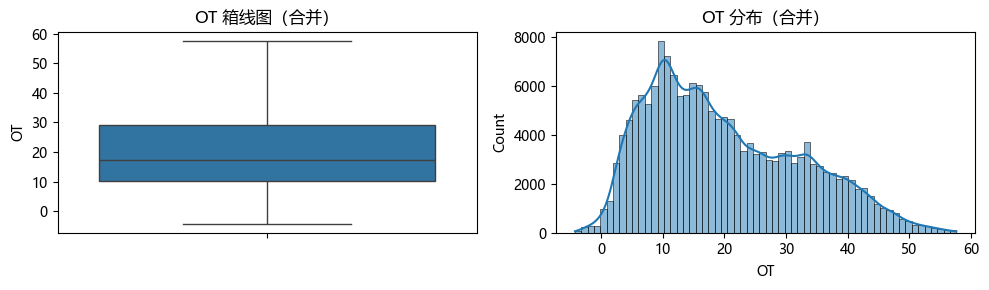

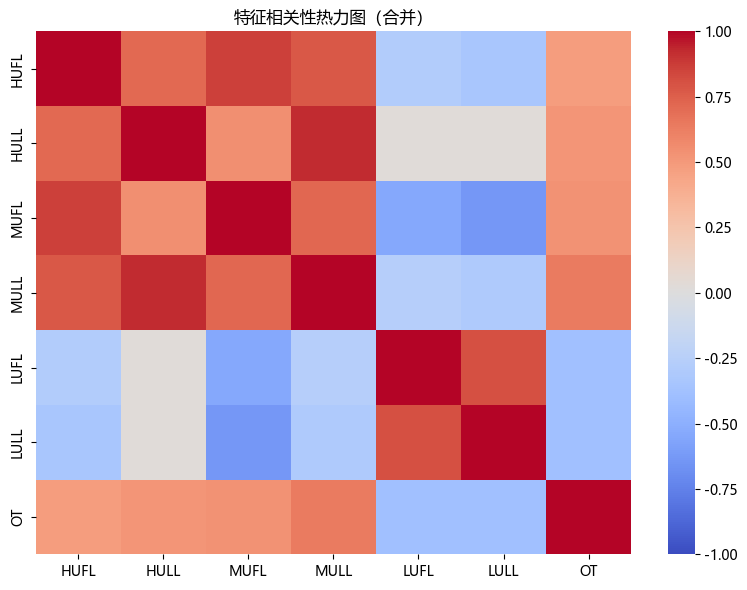

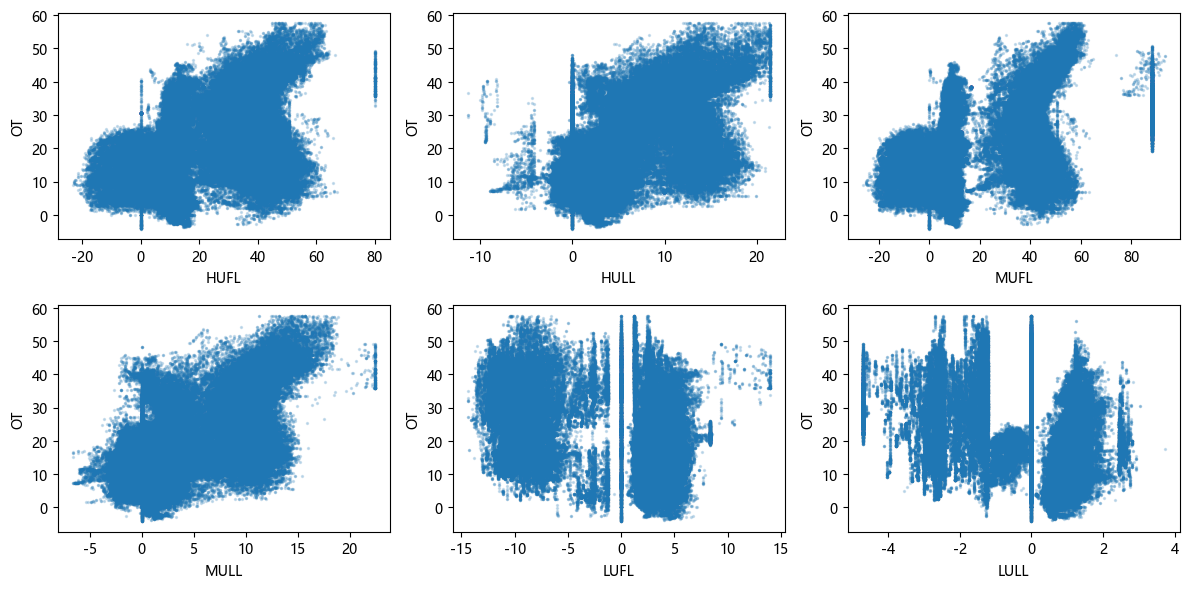

ADF: stat=-8.3894, p=0.000000


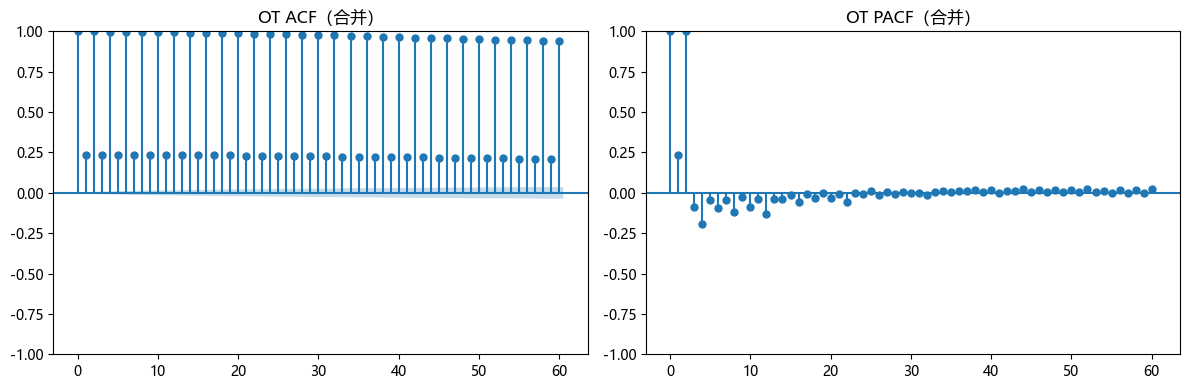

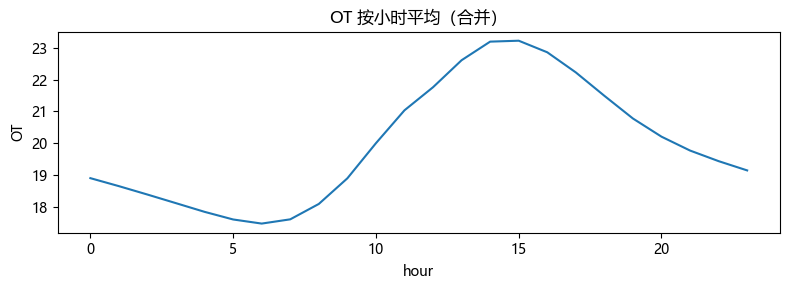

合并后分析全部完成。


In [37]:
# 汇总四个数据集后统一处理与分析（合并再处理）
from datetime import datetime

# 可配置项（与单集一致）
REMOVE_OUTLIER_ROWS = False
WINSORIZE = True
USE_STANDARD_SCALER = True

# 1) 读取并合并
csv_candidates = ['ETTh1.csv','ETTh2.csv','ETTm1.csv','ETTm2.csv']
csv_list = [c for c in csv_candidates if (DATA_DIR / c).exists()]
assert len(csv_list) > 0, f"未在 {DATA_DIR} 下找到 ETT CSV 文件"
print('合并以下数据集:', csv_list)

frames = []
for csv_file in csv_list:
    path = DATA_DIR / csv_file
    _df = pd.read_csv(path)
    _df['date'] = pd.to_datetime(_df['date'])
    _df['dataset'] = csv_file.replace('.csv','')
    frames.append(_df)

combined_df = pd.concat(frames, axis=0, ignore_index=True)
combined_df = combined_df.sort_values(['date','dataset']).drop_duplicates(subset=['date','dataset']).reset_index(drop=True)
print('合并后形状:', combined_df.shape)

# 2) 清洗前基本信息
print('列名:', list(combined_df.columns))
value_cols = [c for c in combined_df.columns if c not in ['date','dataset']]
print('数值列:', value_cols)

# 3) 缺失值插补
imputer = SimpleImputer(strategy='median')
combined_df[value_cols] = imputer.fit_transform(combined_df[value_cols])

# 4) IQR 异常检测
Q1 = combined_df[value_cols].quantile(0.25)
Q3 = combined_df[value_cols].quantile(0.75)
IQR = Q3 - Q1
is_outlier = (combined_df[value_cols] < (Q1 - 1.5 * IQR)) | (combined_df[value_cols] > (Q3 + 1.5 * IQR))
combined_df['outlier_any'] = is_outlier.any(axis=1)
print('合并数据含任一异常比例:', combined_df['outlier_any'].mean())

# 5) 清洗（删除/截尾）
clean_df = combined_df.copy()
if REMOVE_OUTLIER_ROWS:
    clean_df = clean_df[~clean_df['outlier_any']].reset_index(drop=True)
if WINSORIZE:
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    for col in value_cols:
        clean_df[col] = clean_df[col].clip(lower[col], upper[col])
print('清洗后形状:', clean_df.shape)

# 6) 缩放
scaler = StandardScaler() if USE_STANDARD_SCALER else MinMaxScaler()
scaled_values = scaler.fit_transform(clean_df[value_cols])
scaled_df = clean_df[['date','dataset']].copy()
scaled_df[value_cols] = scaled_values

# 7) 导出合并清洗与缩放数据
clean_path = CLEAN_DIR / 'ALL_combined_clean.csv'
scaled_path = CLEAN_DIR / 'ALL_combined_scaled.csv'
clean_df.to_csv(clean_path, index=False)
scaled_df.to_csv(scaled_path, index=False)
print('已导出:', clean_path)
print('已导出:', scaled_path)

# 8) 可视化与分析（在合并数据上）
# OT 概览
plt.figure(figsize=(12, 3))
plt.plot(clean_df['date'], clean_df['OT'], linewidth=0.6, alpha=0.7)
plt.title('OT 概览（合并）')
plt.xlabel('date')
plt.ylabel('OT')
plt.tight_layout()
plt.savefig(FIG_DIR / 'ALL_ot_overview.png', dpi=150)
plt.show()

# 箱线图与直方图
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.boxplot(y=clean_df['OT'], ax=axes[0])
axes[0].set_title('OT 箱线图（合并）')
sns.histplot(clean_df['OT'], kde=True, ax=axes[1], bins=60)
axes[1].set_title('OT 分布（合并）')
plt.tight_layout()
plt.savefig(FIG_DIR / 'ALL_ot_box_hist.png', dpi=150)
plt.show()

# 相关性热力图
corr = clean_df[value_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('特征相关性热力图（合并）')
plt.tight_layout()
plt.savefig(FIG_DIR / 'ALL_corr_heatmap.png', dpi=150)
plt.show()

# OT 与部分特征散点
load_cols = [c for c in value_cols if c != 'OT']
num_to_plot = min(6, len(load_cols))
fig, axes = plt.subplots(2, (num_to_plot + 1) // 2, figsize=(12, 6))
axes = axes.flatten()
for i, col in enumerate(load_cols[:num_to_plot]):
    axes[i].scatter(clean_df[col], clean_df['OT'], s=2, alpha=0.2)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('OT')
plt.tight_layout()
plt.savefig(FIG_DIR / 'ALL_ot_scatter.png', dpi=150)
plt.show()

# ADF、ACF、PACF（合并）
ot_series = clean_df.set_index('date')['OT']
try:
    adf_stat, p_value, usedlag, nobs, crit, icbest = adfuller(ot_series.dropna(), autolag='AIC')
    print(f'ADF: stat={adf_stat:.4f}, p={p_value:.6f}')
except Exception as e:
    print('ADF 检验失败:', e)

lag_n = 60  # 合并后频率不一，统一看较短滞后
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sm.graphics.tsa.plot_acf(ot_series, lags=lag_n, ax=axes[0])
sm.graphics.tsa.plot_pacf(ot_series, lags=lag_n, ax=axes[1], method='ywm')
axes[0].set_title('OT ACF（合并）')
axes[1].set_title('OT PACF（合并）')
plt.tight_layout()
plt.savefig(FIG_DIR / 'ALL_ot_acf_pacf.png', dpi=150)
plt.show()

# 小时季节性（合并）
df_hour = clean_df.copy()
df_hour['hour'] = df_hour['date'].dt.hour
hour_mean = df_hour.groupby('hour')['OT'].mean()
plt.figure(figsize=(8,3))
plt.plot(hour_mean.index, hour_mean.values)
plt.title('OT 按小时平均（合并）')
plt.xlabel('hour')
plt.ylabel('OT')
plt.tight_layout()
plt.savefig(FIG_DIR / 'ALL_ot_hourly_mean.png', dpi=150)
plt.show()

print('合并后分析全部完成。')



原始形状: (17420, 8)
列名: ['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
count,17420,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000
mean,2017-06-28 21:30:00,7.375141,2.242242,4.300239,0.881568,3.066062,0.856932,13.324672
min,2016-07-01 00:00:00,-22.705999,-4.756000,-25.087999,-5.934000,-1.188000,-1.371000,-4.080000
25%,2016-12-29 10:45:00,5.827000,0.737000,3.296000,-0.284000,2.315000,0.670000,6.964000
50%,2017-06-28 21:30:00,8.774000,2.210000,5.970000,0.959000,2.833000,0.975000,11.396000
75%,2017-12-27 08:15:00,11.788000,3.684000,8.635000,2.203000,3.625000,1.218000,18.079000
max,2018-06-26 19:00:00,23.643999,10.114000,17.341000,7.747000,8.498000,3.046000,46.007000
std,NaN,7.067744,2.042342,6.826978,1.809293,1.164506,0.599552,8.566946


缺失值统计:
 date    0
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64
数据类型:
 date    datetime64[ns]
HUFL           float64
HULL           float64
MUFL           float64
MULL           float64
LUFL           float64
LULL           float64
OT             float64
dtype: object


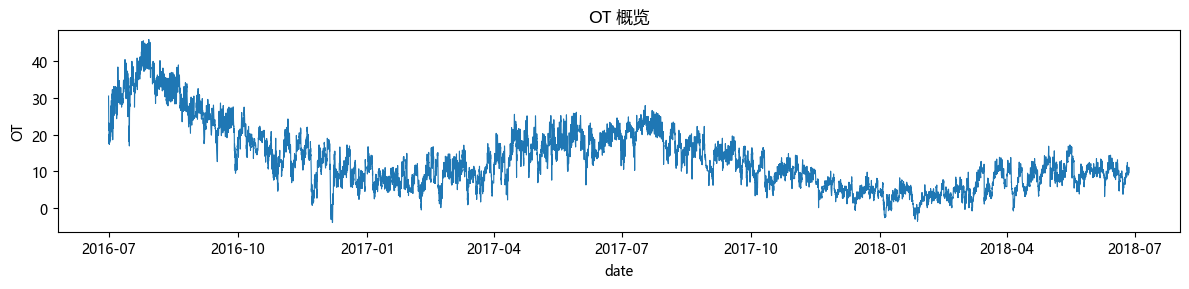

In [38]:
# 加载与基本检查
assert DATA_PATH.exists(), f'数据文件不存在: {DATA_PATH}'

df = pd.read_csv(DATA_PATH)
print('原始形状:', df.shape)
print('列名:', list(df.columns))

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
df = df.drop_duplicates(subset=['date'])

# 简要预览
display(df.head())
display(df.describe(include='all'))

# 基本信息
missing_summary = df.isna().sum()
print('缺失值统计:\n', missing_summary)

dtypes_info = df.dtypes
print('数据类型:\n', dtypes_info)

# 可视化：OT 概览
plt.figure(figsize=(12, 3))
plt.plot(df['date'], df['OT'], linewidth=0.8)
plt.title('OT 概览')
plt.xlabel('date')
plt.ylabel('OT')
plt.tight_layout()
plt.savefig(FIG_DIR / f'{CSV_FILE}_ot_overview.png', dpi=150)
plt.show()


缺失比例:
 HUFL    0.0
HULL    0.0
MUFL    0.0
MULL    0.0
LUFL    0.0
LULL    0.0
OT      0.0
dtype: float64
异常占比(列级):
 HUFL    0.104707
HULL    0.002928
MUFL    0.115098
MULL    0.004478
LUFL    0.032204
LULL    0.098393
OT      0.027038
dtype: float64
含任一异常的样本比例: 0.25878300803673937


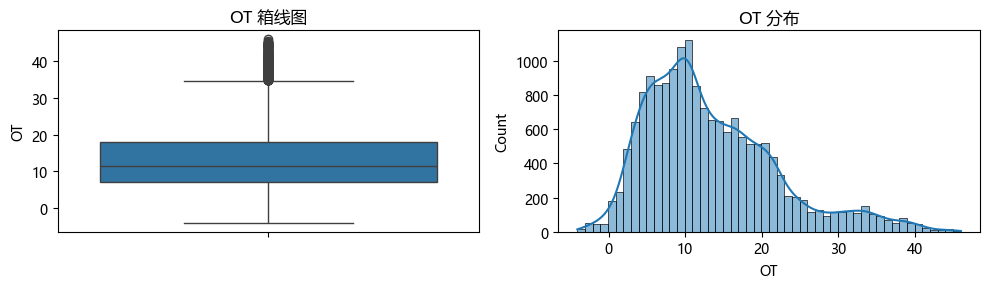

In [39]:
# 缺失值与异常值检测
value_cols = [c for c in df.columns if c != 'date']

# 缺失值简单插补（记录缺失比例）
missing_ratio = df[value_cols].isna().mean()
print('缺失比例:\n', missing_ratio)

imputer = SimpleImputer(strategy='median')
df[value_cols] = imputer.fit_transform(df[value_cols])

# IQR 法检测异常值（标记但暂不删除）
Q1 = df[value_cols].quantile(0.25)
Q3 = df[value_cols].quantile(0.75)
IQR = Q3 - Q1

is_outlier = (df[value_cols] < (Q1 - 1.5 * IQR)) | (df[value_cols] > (Q3 + 1.5 * IQR))
outlier_rate = is_outlier.mean()
print('异常占比(列级):\n', outlier_rate)

df['outlier_any'] = is_outlier.any(axis=1)
print('含任一异常的样本比例:', df['outlier_any'].mean())

# 可视化：OT 的箱线图与分布
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.boxplot(y=df['OT'], ax=axes[0])
axes[0].set_title('OT 箱线图')
sns.histplot(df['OT'], kde=True, ax=axes[1], bins=50)
axes[1].set_title('OT 分布')
plt.tight_layout()
plt.savefig(FIG_DIR / f'{CSV_FILE}_ot_box_hist.png', dpi=150)
plt.show()


In [40]:
# 清洗策略与缩放（可切换）
# 1) 对含异常的样本：可选择删除或 Winsorize（截尾）
REMOVE_OUTLIER_ROWS = False
WINSORIZE = True

clean_df = df.copy()

if REMOVE_OUTLIER_ROWS:
    clean_df = clean_df[~clean_df['outlier_any']].reset_index(drop=True)
    print('删除异常样本后形状:', clean_df.shape)

if WINSORIZE:
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    for col in value_cols:
        clean_df[col] = clean_df[col].clip(lower[col], upper[col])
    print('已对数值列进行截尾处理')

# 2) 特征缩放：选择标准化或归一化
USE_STANDARD_SCALER = True

scaler = StandardScaler() if USE_STANDARD_SCALER else MinMaxScaler()
scaled_values = scaler.fit_transform(clean_df[value_cols])
scaled_df = clean_df[['date']].copy()
scaled_df[value_cols] = scaled_values

print('缩放后预览:')
display(scaled_df.head())

# 导出清洗与缩放数据
clean_path = CLEAN_DIR / f'{CSV_FILE.replace(".csv", "")}_clean.csv'
scaled_path = CLEAN_DIR / f'{CSV_FILE.replace(".csv", "")}_scaled.csv'
clean_df.to_csv(clean_path, index=False)
scaled_df.to_csv(scaled_path, index=False)
print('已导出:', clean_path)
print('已导出:', scaled_path)


已对数值列进行截尾处理
缩放后预览:


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,-0.393541,-0.114090,-0.708830,-0.233655,1.114219,0.910759,2.085445
1,2016-07-01 01:00:00,-0.417765,-0.081200,-0.730580,-0.253664,1.056111,0.975469,1.754684
2,2016-07-01 02:00:00,-0.514658,-0.245652,-0.773877,-0.293128,0.708415,0.656096,1.754684
3,2016-07-01 03:00:00,-0.526770,-0.146980,-0.773877,-0.273118,0.736993,0.783428,1.424042
4,2016-07-01 04:00:00,-0.478323,-0.146980,-0.730580,-0.233655,0.795101,0.783428,1.050851


已导出: outputs\cleaned\ETTh1_clean.csv
已导出: outputs\cleaned\ETTh1_scaled.csv


相关性矩阵（前 5 行）:


,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
HUFL,1.000000,0.206568,0.981616,0.135521,0.364794,0.066153,0.051753
HULL,0.206568,1.000000,0.180072,0.930353,0.283467,0.410250,0.228702
MUFL,0.981616,0.180072,1.000000,0.136374,0.221811,-0.019412,0.046078
MULL,0.135521,0.930353,0.136374,1.000000,0.136355,0.112889,0.229117
LUFL,0.364794,0.283467,0.221811,0.136355,1.000000,0.413287,0.082977


与 OT 的相关性排序:
OT      1.000000
MULL    0.229117
HULL    0.228702
LULL    0.107587
LUFL    0.082977
HUFL    0.051753
MUFL    0.046078
Name: OT, dtype: float64


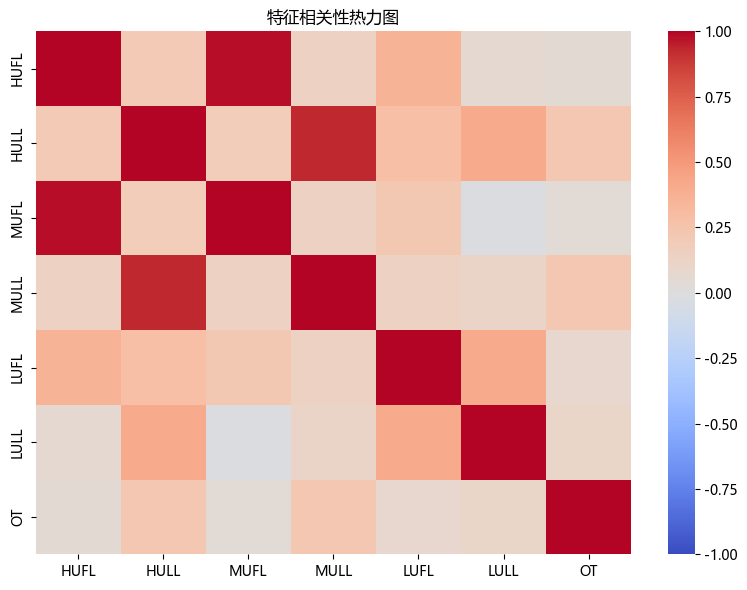

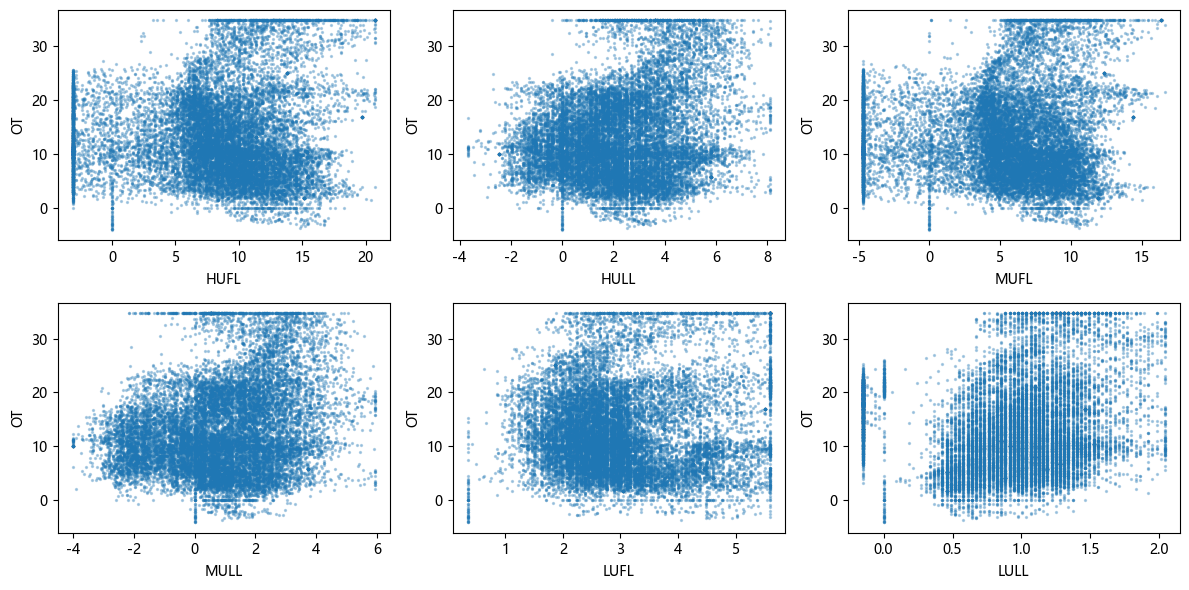

In [41]:
# 与 OT 的相关性分析
corr = clean_df[value_cols].corr()
print('相关性矩阵（前 5 行）:')
display(corr.head())

# 与 OT 的 Pearson 相关系数
ot_corr = corr['OT'].sort_values(ascending=False)
print('与 OT 的相关性排序:')
print(ot_corr)

# 热力图
plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('特征相关性热力图')
plt.tight_layout()
plt.savefig(FIG_DIR / f'{CSV_FILE}_corr_heatmap.png', dpi=150)
plt.show()

# OT 与各负荷的散点关系
load_cols = [c for c in value_cols if c != 'OT']
num_to_plot = min(6, len(load_cols))
fig, axes = plt.subplots(2, (num_to_plot + 1) // 2, figsize=(12, 6))
axes = axes.flatten()
for i, col in enumerate(load_cols[:num_to_plot]):
    axes[i].scatter(clean_df[col], clean_df['OT'], s=2, alpha=0.3)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('OT')
plt.tight_layout()
plt.savefig(FIG_DIR / f'{CSV_FILE}_ot_scatter.png', dpi=150)
plt.show()


ADF Statistic: -3.5540, p-value: 0.006704


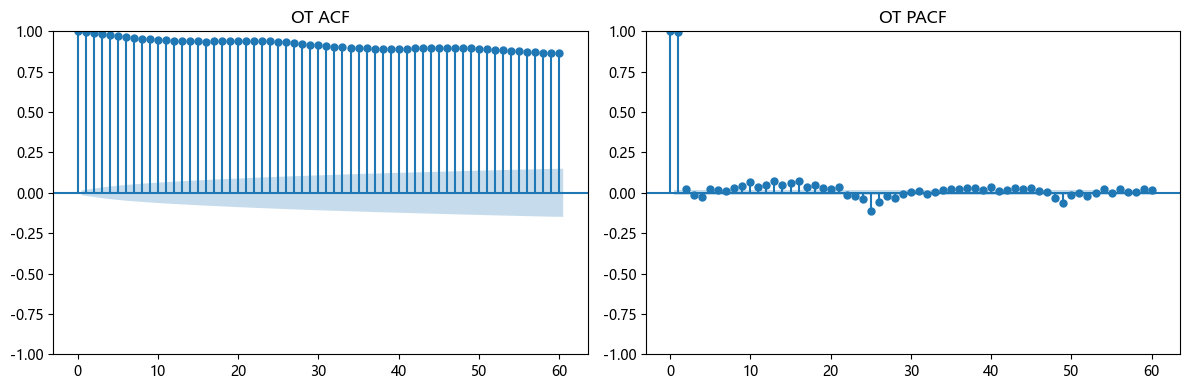

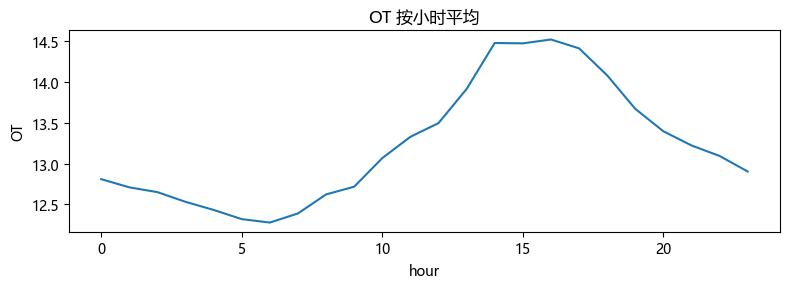

In [42]:
# 时序特性：平稳性与自相关
ot_series = clean_df.set_index('date')['OT']

# ADF 检验
adf_stat, p_value, usedlag, nobs, crit, icbest = adfuller(ot_series.dropna(), autolag='AIC')
print(f'ADF Statistic: {adf_stat:.4f}, p-value: {p_value:.6f}')

# ACF/PACF
lag_n = 60 if 'm' not in CSV_FILE else 24 * 7  # 小时数据看 60, 分钟数据看一周
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sm.graphics.tsa.plot_acf(ot_series, lags=lag_n, ax=axes[0])
sm.graphics.tsa.plot_pacf(ot_series, lags=lag_n, ax=axes[1], method='ywm')
axes[0].set_title('OT ACF')
axes[1].set_title('OT PACF')
plt.tight_layout()
plt.savefig(FIG_DIR / f'{CSV_FILE}_ot_acf_pacf.png', dpi=150)
plt.show()

# 季节性可视化（小时/星期聚合）
df_hour = clean_df.copy()
df_hour['hour'] = df_hour['date'].dt.hour
hour_mean = df_hour.groupby('hour')['OT'].mean()

plt.figure(figsize=(8,3))
plt.plot(hour_mean.index, hour_mean.values)
plt.title('OT 按小时平均')
plt.xlabel('hour')
plt.ylabel('OT')
plt.tight_layout()
plt.savefig(FIG_DIR / f'{CSV_FILE}_ot_hourly_mean.png', dpi=150)
plt.show()


## 使用说明
- 在第二个代码单元中通过修改 `CSV_FILE` 切换数据源（ETTh1/ETTh2/ETTm1/ETTm2）。
- 通过 `REMOVE_OUTLIER_ROWS` 与 `WINSORIZE` 切换异常处理策略。
- 通过 `USE_STANDARD_SCALER` 切换 StandardScaler / MinMaxScaler。
- 运行全部单元后，清洗数据与缩放数据将分别导出到 `project/first/outputs/cleaned/`，图表导出到 `project/first/outputs/figures/`。
- 数据字段含义参考数据集官方说明与中文文档。

参考资料：数据集官方仓库 [`ETDataset`](https://github.com/zhouhaoyi/ETDataset)
